In [20]:
from datetime import datetime, timedelta

download_names_list = []

start_year_zip = 2018
start_date = "20230101"
end_date = "20250105"

name_list = []
current_date = datetime.strptime(start_date, "%Y%m%d")
end_date_datetime = datetime.strptime(end_date, "%Y%m%d")

while current_date <= end_date_datetime:
    name_list.append(current_date.strftime("%Y%m%d"))
    current_date += timedelta(days=1)

for date in name_list:
    download_names_list.append(f"{date}")

years = range(start_year_zip, 2023)
for year in years:
    download_names_list.append(f"{year}.zip")


In [21]:
import aiohttp
import asyncio
from aiohttp import TCPConnector
from aiolimiter import AsyncLimiter

async def download_file_with_versions(session, base_url, name):
    """
    Attempt to download a file for a given name.
    If the name ends with '.zip', download it directly.
    Otherwise, try versions .1 to .6.
    Returns the first successfully downloaded file's content or None if all fail.
    """
    # Check if the name ends with '.zip'
    if name.endswith(".zip"):
        file_name = name
        url = base_url + file_name
        try:
            headers = {"User-Agent": "Mozilla/5.0"}  # Add headers if needed
            async with session.get(url, headers=headers) as response:
                if response.status == 200:
                    # Successfully downloaded
                    content = await response.read()
                    return file_name, content
                else:
                    print(f"Failed to download {url} with status {response.status}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        # If the .zip file fails, return None
        return None, None

    # If not a .zip file, try versions .1 to .6
    for version in range(1, 10):  # Try versions .1 to .6
        file_name = f"{name}.{version}"
        url = base_url + file_name
        try:
            headers = {"User-Agent": "Mozilla/5.0"}  # Add headers if needed
            async with session.get(url, headers=headers) as response:
                if response.status == 200:
                    # Successfully downloaded
                    content = await response.read()
                    return file_name, content
                else:
                    print(f"Skipped {file_name}. Fetching version {version+1}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
    # If all versions fail, return None
    raise ValueError(f"Failed to download {name}")

async def download_all_files(base_url, name_list):
    """
    Download all files for the given dates, trying versions .1 to .6 for each name.
    Returns a dictionary with file names as keys and content as values.
    """
    async with aiohttp.ClientSession() as session:
        tasks = [download_file_with_versions(session, base_url, name) for name in name_list]
        results = await asyncio.gather(*tasks)
        # Print failed downloads
        for file_name, content in results:
            if content is None:
                print(f"Failed to download any version for {file_name}")
        # Create a dictionary from the results, filtering out failed downloads (None values)
        return {file_name: content for file_name, content in results if content is not None}

# Example usage
base_url = "https://www.omie.es/pt/file-download?parents=marginalpdbcpt&filename=marginalpdbcpt_" # diario
# base_url = "https://www.omie.es/pt/file-download?parents=marginalpibcpt&filename=marginalpibcpt_" # intradiario

data = await download_all_files(base_url, download_names_list)

Skipped 20230223.1. Fetching version 2
Skipped 20230121.1. Fetching version 2
Skipped 20230528.1. Fetching version 2
Skipped 20230121.2. Fetching version 3


In [22]:
import pandas as pd
from datetime import datetime
import zipfile
from io import BytesIO
pd.set_option('display.width', 100)


def parse_plain_text(content):
    """
    Parses plain text data and returns a list of rows.
    """
    # Decode content if it's in bytes
    if isinstance(content, bytes):
        content = content.decode('utf-8')  # Adjust encoding if necessary

    lines = content.strip().split('\n')
    all_rows = []
    for line in lines:
        if line.startswith("MARGINALPDBCPT") or not line.strip():
            continue  # Skip header or empty lines
        parts = line.split(';')
        if len(parts) >= 6:
            year, month, day, hour, value1, value2 = parts[:6]
            all_rows.append({
                "Year": year,
                "Month": month,
                "Day": day,
                "HourSlot": hour,
                "PT": value1,
                "ES": value2
            })
    return all_rows

def parse_zip_file(content):
    """
    Parses ZIP file data and returns a list of rows by extracting and parsing each `.1` file inside.
    
    Parameters:
    - content (bytes): The binary content of the ZIP file.
    
    Returns:
    - list of dict: Parsed data rows from all `.1` files within the ZIP.
    """
    all_rows = []
    with zipfile.ZipFile(BytesIO(content)) as z:
        for file_info in z.infolist():
            if any(file_info.filename.endswith(f'.{i}') for i in range(1, 10)):
                with z.open(file_info) as f:
                    file_content = f.read().decode('utf-8')
                    all_rows.extend(parse_plain_text(file_content))
    return all_rows


def process_data(data_dict):
    """
    Process the downloaded data (both .1 and .zip files) and return a DataFrame.

    Parameters:
    - data_dict (dict): A dictionary where keys are file names and values are file contents.

    Returns:
    - pd.DataFrame: Processed data with a combined datetime column in UTC.
    """
    all_rows = []
    for file_name, content in data_dict.items():
        if file_name.endswith(".zip"):
            all_rows.extend(parse_zip_file(content))
        else:
            all_rows.extend(parse_plain_text(content))
    
    # Create DataFrame from all rows
    df = pd.DataFrame(all_rows, columns=["Year", "Month", "Day", "HourSlot", "PT", "ES"])

    # Convert appropriate columns to numeric types
    df["Year"] = df["Year"].astype(int)
    df["Month"] = df["Month"].astype(int)
    df["Day"] = df["Day"].astype(int)
    df["HourSlot"] = df["HourSlot"].astype(int)  # <-- Modified Line
    df["PT"] = pd.to_numeric(df["PT"], errors='raise')
    df["ES"] = pd.to_numeric(df["ES"], errors='raise')

    df['base_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df.sort_values(by=['base_date', 'HourSlot'], inplace=True)

    list_23 = list(range(24))
    list_23.remove(2)
    list_24 = list(range(24))
    list_25 = list(range(24))
    list_25.append(2)
    list_25.sort()


    def _slot_to_hour(group):
        group_size = len(group)
        if group_size == 23:
            group['Hour'] = list_23
        elif group_size == 24:
            group['Hour'] = list_24
        elif group_size == 25:
            group['Hour'] = list_25
        else:
            raise ValueError
        return group

    df = df.groupby('base_date').apply(_slot_to_hour).reset_index(drop = True)
    # print(df[df.base_date=="20180625"])
    df['datetime'] = pd.to_datetime(
        dict(
            year=df['Year'],
            month=df['Month'],
            day=df['Day'],
            hour=df['Hour']
        ),
        errors='raise'  # handle invalid dates if any
    )
    # print(df[df.datetime==pd.Timestamp("2023-10-01").date()])

    df['datetime_cet'] = df['datetime'].dt.tz_localize(
        'Europe/Madrid',
        # Handle ambiguous times (e.g. fall back):
        ambiguous='infer', 
        # Handle nonexistent times (e.g. spring forward):
        nonexistent='raise'
    )

    # 4) Convert to UTC
    df['datetime'] = df['datetime_cet'].dt.tz_convert('UTC').dt.tz_localize(None)
    
    # # Drop the separate Year, Month, Day, and Hour columns
    df.drop(columns=["Year", "Month", "Day", "Hour", "HourSlot", "base_date"], inplace=True)
    df.drop(columns=["datetime_cet"], inplace=True)

    df.set_index("datetime", inplace=True)
    df.sort_index(inplace=True)
    
    return df

prices_df_all = process_data(data)
prices_df_all



,PT,ES
datetime,,
2017-12-31 23:00:00,28.10,6.74
2018-01-01 00:00:00,33.00,4.74
2018-01-01 01:00:00,32.90,3.66
2018-01-01 02:00:00,28.10,2.30
2018-01-01 03:00:00,27.60,2.30
...,...,...
2025-01-05 18:00:00,64.81,64.81
2025-01-05 19:00:00,65.20,65.20
2025-01-05 20:00:00,68.50,68.50


In [23]:
# prices_df = prices_df_all.loc["2024"]
prices_df = prices_df_all[1:]

In [24]:
prices_df

,PT,ES
datetime,,
2018-01-01 00:00:00,33.00,4.74
2018-01-01 01:00:00,32.90,3.66
2018-01-01 02:00:00,28.10,2.30
2018-01-01 03:00:00,27.60,2.30
2018-01-01 04:00:00,24.60,2.06
...,...,...
2025-01-05 18:00:00,64.81,64.81
2025-01-05 19:00:00,65.20,65.20
2025-01-05 20:00:00,68.50,68.50


In [25]:
aggregated.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00',
               ...
               '2025-01-05 13:00:00', '2025-01-05 14:00:00', '2025-01-05 15:00:00',
               '2025-01-05 16:00:00', '2025-01-05 17:00:00', '2025-01-05 18:00:00',
               '2025-01-05 19:00:00', '2025-01-05 20:00:00', '2025-01-05 21:00:00',
               '2025-01-05 22:00:00'],
              dtype='datetime64[ns]', name='start_time', length=61487, freq=None)

In [26]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "src"))
from data_fetcher import ENTSOEDataFetcher
import nest_asyncio
from data_fetcher import SimpleInterval
from datetime import datetime
from analyzer import analyze

nest_asyncio.apply()

# Apply nest_asyncio to allow nested event loops (useful for Jupyter notebooks)
fetcher = ENTSOEDataFetcher()

data_request = SimpleInterval(datetime(2018, 1,1,0), datetime(2025, 1,5,23))
fetcher_data = fetcher.get_data(data_request)

# Analyze the data to get aggregated and contributions DataFrames
aggregated, contributions = analyze(fetcher_data)
# aggregated.columns = aggregated.columns.map(lambda x: utils.PSR_TYPE_MAPPING.get(x, x))

# assert prices_df.index.equals(aggregated.index)
if not prices_df.index.equals(aggregated.index):
    print("Indexes do not match!")
    diff1 = prices_df.index.difference(aggregated.index)
    diff2 = aggregated.index.difference(prices_df.index)
    print("\nIndexes in prices_df but not in aggregated:")
    print(diff1)
    print("\nIndexes in aggregated but not in prices_df:")
    print(diff2)
else:
    print("Indexes match.")

[async_get_physical_flows] Start: 16:05:24, End: 16:05:24, took 0.04s: from: 10YPT-REN------W to 10YES-REE------0
[async_get_physical_flows] Start: 16:05:24, End: 16:05:24, took 0.04s: from: 10YES-REE------0 to 10YPT-REN------W
[async_get_physical_flows] Start: 16:05:24, End: 16:05:24, took 0.05s: from: 10YES-REE------0 to 10YFR-RTE------C
[async_get_physical_flows] Start: 16:05:24, End: 16:05:24, took 0.06s: from: 10YFR-RTE------C to 10YES-REE------0
[async_get_generation_data] Start: 16:05:24, End: 16:05:24, took 0.08s: country: 10YPT-REN------W
[async_get_generation_data] Start: 16:05:24, End: 16:05:24, took 0.10s: country: 10YFR-RTE------C
[async_get_generation_data] Start: 16:05:24, End: 16:05:24, took 0.12s: country: 10YES-REE------0
[get_data] total duration: 0.1167447566986084s
Indexes match.


In [27]:
# imports = contributions["ES"].add(contributions["FR"], fill_value=0).sum(axis=1, skipna=True)
imports = fetcher_data.flow_es_to_pt["Power"]
exports = fetcher_data.flow_pt_to_es["Power"]
# exports = data
consumption = aggregated.sum(axis=1, skipna=True)

percentage_imports = imports.div(consumption)*100


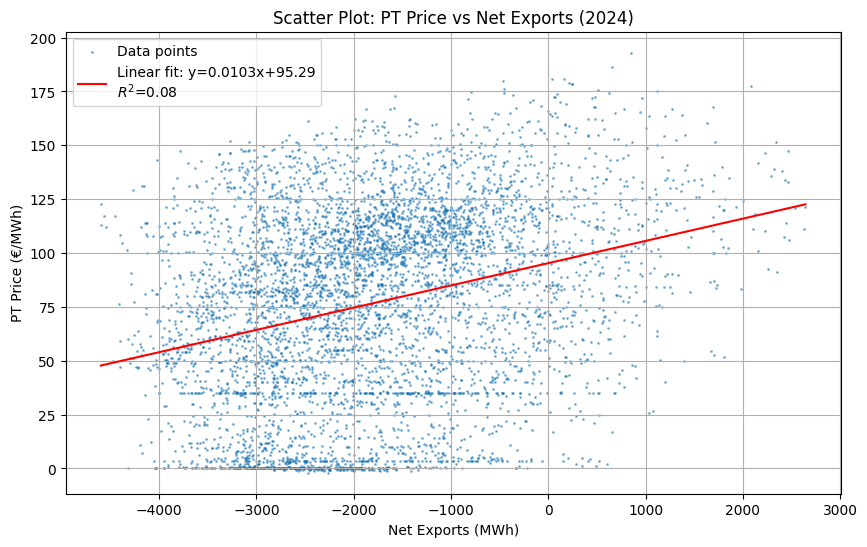

In [39]:
import numpy as np
from scipy.stats import linregress

net_exports = exports - imports
prices_pt = prices_df["PT"]

mask = np.logical_and(prices_df.index.year == 2024, prices_df.index.month >4)
net_exports = net_exports[mask]
prices_pt = prices_pt[mask]

import matplotlib.pyplot as plt

# Calculate the linear regression parameters
slope, intercept, r_value, p_value, std_err = linregress(net_exports, prices_pt)

# Generate a smooth line for the regression
x_vals = np.linspace(net_exports.min(), net_exports.max(), 100)
y_vals = intercept + slope * x_vals

plt.figure(figsize=(10, 6))
plt.scatter(net_exports, prices_pt, alpha=0.5, s=1, label='Data points')
plt.plot(x_vals, y_vals, color='red', label=f'Linear fit: y={slope:.4f}x+{intercept:.2f}\n$R^2$={r_value**2:.2f}')
plt.xlabel("Net Exports (MWh)")
plt.ylabel("PT Price (€/MWh)")
plt.title("Scatter Plot: PT Price vs Net Exports (2024)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
exports.max()

np.float64(3495.0)

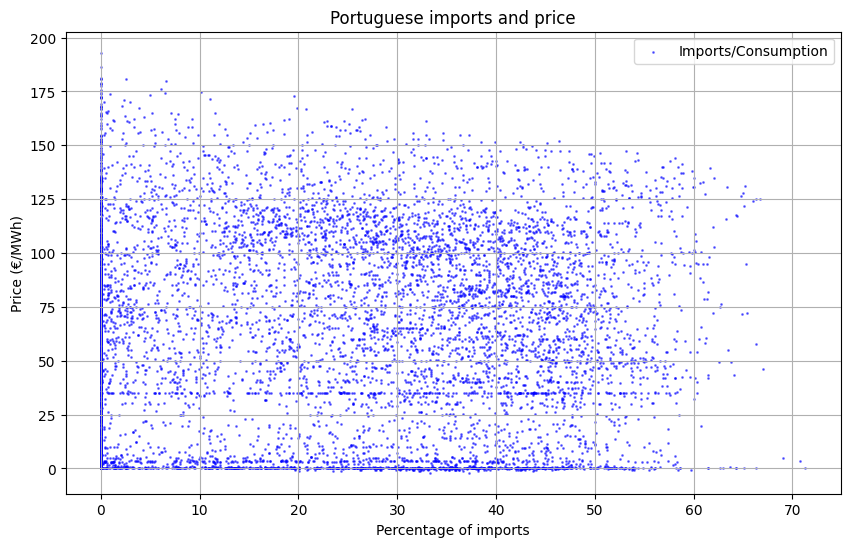

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(percentage_imports, prices_df["PT"], label='Imports/Consumption', color='blue', alpha=0.5, s=1)
plt.title('Portuguese imports and price')
plt.xlabel('Percentage of imports')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()


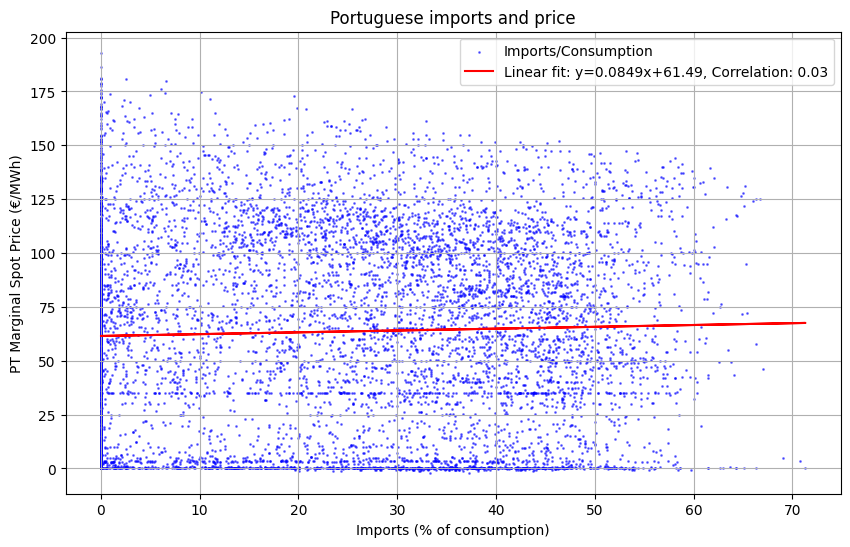

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

x = percentage_imports
y = prices_df["PT"]

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Imports/Consumption', color='blue', alpha=0.5, s=1)

# Plot the regression line
plt.plot(
    x,
    intercept + slope * (x),
    'r',
    label=f'Linear fit: y={slope:.4f}x+{intercept:.2f}, Correlation: {correlation:.2f}'
)

plt.title('Portuguese imports and price')
plt.xlabel('Imports (% of consumption)')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.legend()
plt.grid(True)

plt.show()


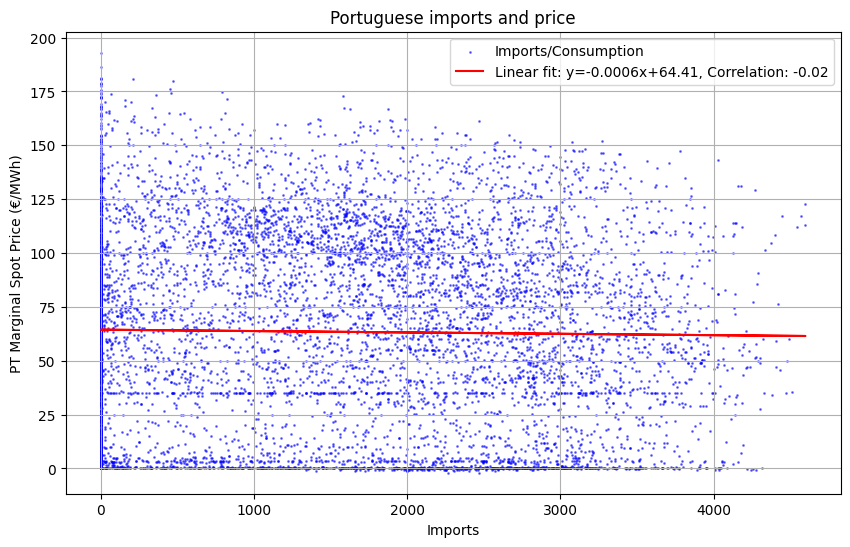

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

x = imports
y = prices_df["PT"]

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Imports/Consumption', color='blue', alpha=0.5, s=1)

# Plot the regression line
plt.plot(
    x,
    intercept + slope * (x),
    'r',
    label=f'Linear fit: y={slope:.4f}x+{intercept:.2f}, Correlation: {correlation:.2f}'
)

plt.title('Portuguese imports and price')
plt.xlabel('Imports')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.legend()
plt.grid(True)

plt.show()

In [11]:
import plotly.express as px

# Create the violin plot without adding a 'Month' column
fig = px.violin(
    prices_df,
    x=prices_df.index.month,  # Extract month directly from the index
    y="PT",
    box=True,  # Add a box plot inside the violin
    # points="all",  # Show all points
    title="Distribution of PT Marginal Spot Prices by Month",
    labels={"x": "Month", "PT": "Price (€/MWh)"},  # Update x-axis label
    template="plotly_white"  # Use a clean white background
)

# Show the plot
fig.show()

In [12]:
print(prices_df["PT"].value_counts().head(30))  # Print the top 10 most common rows

indexes_with_negative_001 = prices_df[prices_df["PT"] == -0.01].index
print("Indexes with value -0.01:", indexes_with_negative_001)


PT
 0.00      527
 35.00     135
 3.20      121
 3.25       81
 35.01      75
-0.01       68
 0.44       59
 3.32       45
 5.00       44
 40.00      41
 0.01       37
 0.43       36
 100.00     34
 60.00      32
 90.00      28
 70.00      28
 75.00      27
 85.00      23
 1.00       22
 30.00      22
 80.00      22
 2.00       22
 10.00      22
 65.00      22
 25.00      21
 110.00     20
 3.60       19
 0.10       19
 50.00      19
 35.02      18
Name: count, dtype: int64
Indexes with value -0.01: DatetimeIndex(['2024-04-05 12:00:00', '2024-04-05 13:00:00', '2024-04-06 08:00:00',
               '2024-04-06 09:00:00', '2024-04-06 10:00:00', '2024-04-06 11:00:00',
               '2024-04-06 12:00:00', '2024-04-06 13:00:00', '2024-04-06 14:00:00',
               '2024-04-06 15:00:00', '2024-04-07 11:00:00', '2024-04-07 12:00:00',
               '2024-04-07 13:00:00', '2024-04-07 14:00:00', '2024-04-08 14:00:00',
               '2024-04-09 09:00:00', '2024-04-09 10:00:00', '2024-04-09 11

In [13]:
import plotly.express as px

# Create the violin plot with different colors for each month
fig = px.violin(
    prices_df,
    x=prices_df.index.month,  # Extract month directly from the index
    y="PT",
    color=prices_df.index.month,  # Use month to assign different colors
    box=True,  # Add a box plot inside the violin
    # points="all",  # Show all points
    title="Distribution of PT Marginal Spot Prices by Month",
    labels={"x": "Month", "PT": "Price (€/MWh)", "color": "Month"},  # Update labels
    template="plotly_white"  # Use a clean white background
)

# Adjust the width of the violins
for trace in fig.data:
    trace.width = 0.8  # Set the desired width

# Show the plot
fig.show()


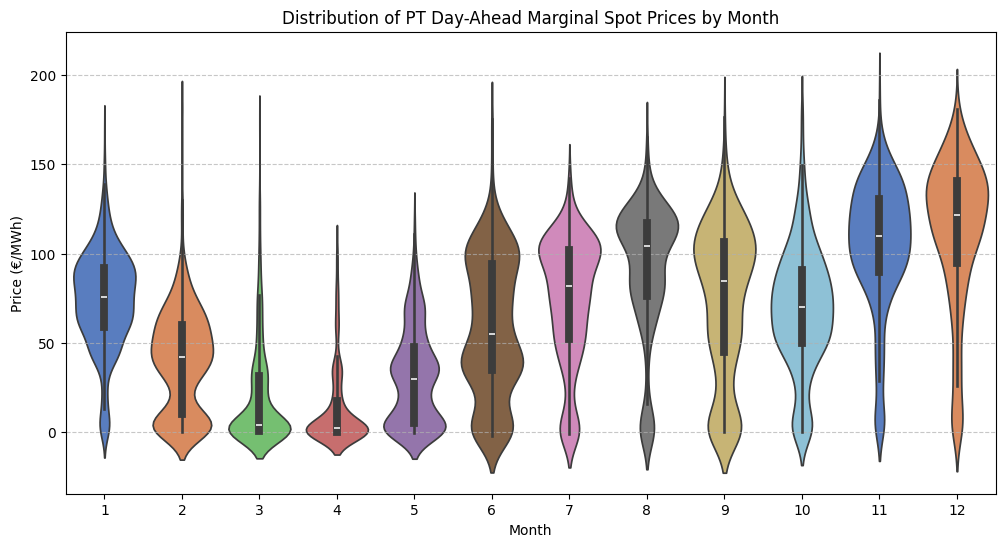

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot without adding a 'Month' column
plt.figure(figsize=(12, 6))
sns.violinplot(
    x=prices_df.index.month,  # Extract month directly from the index
    y=prices_df["PT"],
    palette="muted"
)

# Add labels and title
plt.title("Distribution of PT Day-Ahead Marginal Spot Prices by Month")
plt.xlabel("Month")
plt.ylabel("Price (€/MWh)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

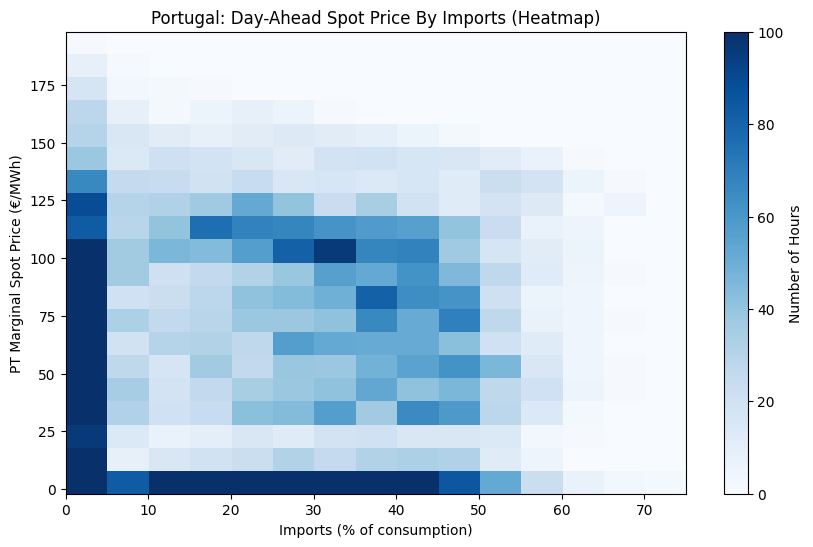

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the bin sizes
x_bin_size = 5  # 5% for x-axis (Imports)
y_bin_size = 10  # 10 €/MWh for y-axis (Price)

# Calculate the bin edges based on the bin sizes
x_min, x_max = percentage_imports.min(), percentage_imports.max()
y_min, y_max = prices_df["PT"].min(), prices_df["PT"].max()

xedges = np.arange(x_min, x_max + x_bin_size, x_bin_size)
yedges = np.arange(y_min, y_max + y_bin_size, y_bin_size)

# Create a 2D histogram (heatmap) for the data
plt.figure(figsize=(10, 6))
heatmap_data, xedges, yedges = np.histogram2d(
    percentage_imports, 
    prices_df["PT"], 
    bins=[xedges, yedges]  # Use the calculated bin edges
)

# Cap the values in the heatmap to a maximum of 200
heatmap_data = np.clip(heatmap_data, None, 100)

# Plot the heatmap
plt.imshow(
    heatmap_data.T,  # Transpose to align axes correctly
    origin='lower',  # Set the origin to the lower-left corner
    aspect='auto',  # Adjust aspect ratio
    cmap="Blues",  # Color map for the heatmap
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]  # Define the extent of the axes
)

# Add a color bar
plt.colorbar(label="Number of Hours")
# cbar = plt.colorbar(label="Number of Hours")
# cbar.set_ticks([0, 50, 100, 150, 200])  # Set ticks to reflect the capped values
# cbar.set_label("Number of Hours (Capped at 200)")

# Add labels and title
plt.title('Portugal: Day-Ahead Spot Price By Imports (Heatmap)')
plt.xlabel('Imports (% of consumption)')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.grid(False)  # Disable grid for heatmap

plt.show()

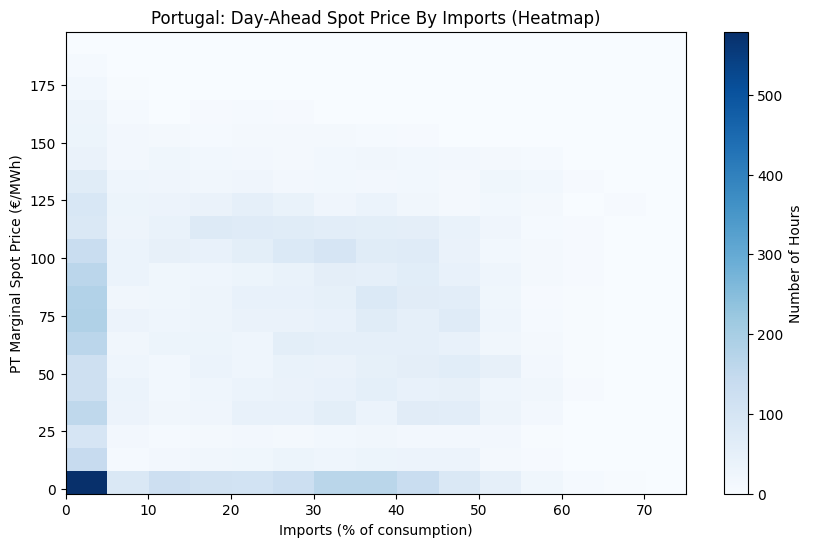

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the bin sizes
x_bin_size = 5  # 5% for x-axis (Imports)
y_bin_size = 10  # 10 €/MWh for y-axis (Price)

# Calculate the bin edges based on the bin sizes
x_min, x_max = percentage_imports.min(), percentage_imports.max()
y_min, y_max = prices_df["PT"].min(), prices_df["PT"].max()

xedges = np.arange(x_min, x_max + x_bin_size, x_bin_size)
yedges = np.arange(y_min, y_max + y_bin_size, y_bin_size)

# Create a 2D histogram (heatmap) for the data
plt.figure(figsize=(10, 6))
heatmap_data, xedges, yedges = np.histogram2d(
    percentage_imports, 
    prices_df["PT"], 
    bins=[xedges, yedges]  # Use the calculated bin edges
)

# Cap the values in the heatmap to a maximum of 200
# heatmap_data = np.clip(heatmap_data, None, 200)

# Plot the heatmap
plt.imshow(
    heatmap_data.T,  # Transpose to align axes correctly
    origin='lower',  # Set the origin to the lower-left corner
    aspect='auto',  # Adjust aspect ratio
    cmap="Blues",  # Color map for the heatmap
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]  # Define the extent of the axes
)

# Add a color bar
plt.colorbar(label="Number of Hours")
# cbar = plt.colorbar(label="Number of Hours")
# cbar.set_ticks([0, 50, 100, 150, 200])  # Set ticks to reflect the capped values
# cbar.set_label("Number of Hours (Capped at 200)")

# Add labels and title
plt.title('Portugal: Day-Ahead Spot Price By Imports (Heatmap)')
plt.xlabel('Imports (% of consumption)')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.grid(False)  # Disable grid for heatmap

plt.show()

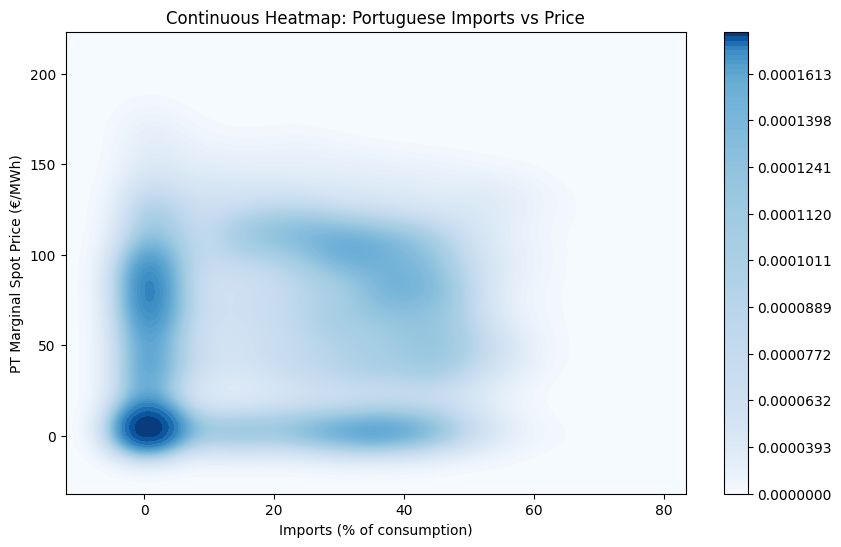

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a continuous heatmap using kernel density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=percentage_imports,
    y=prices_df["PT"],
    cmap="Blues",  # Color map for the heatmap
    fill=True,  # Fill the heatmap
    thresh=0,  # Show all density levels
    levels=100,  # Increase the number of levels for smoother transitions
    cbar=True  # Add a color bar
)

# Add labels and title
plt.title('Continuous Heatmap: Portuguese Imports vs Price')
plt.xlabel('Imports (% of consumption)')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.grid(False)  # Disable grid for heatmap

plt.show()

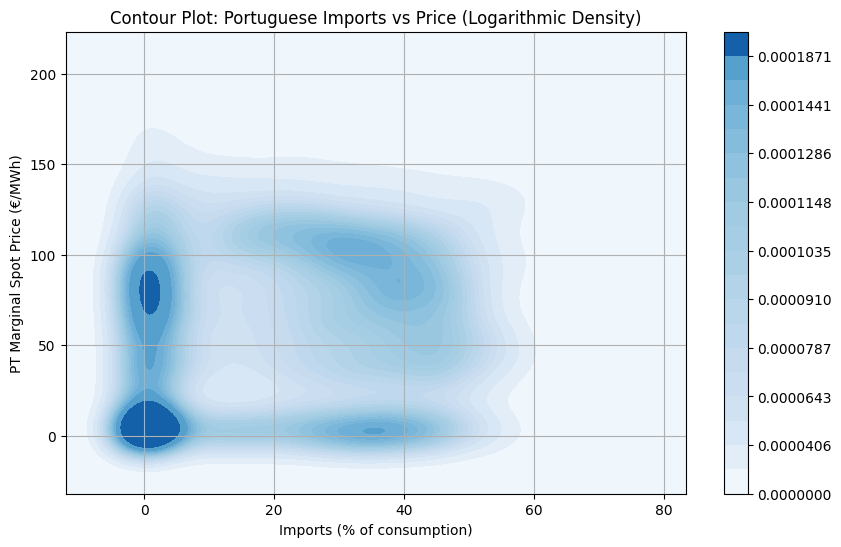

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D histogram (density estimate) for the contour plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=percentage_imports,
    y=prices_df["PT"],
    cmap="Blues",  # Color map for the contours
    fill=True,  # Fill the contours
    thresh=0,  # Show all density levels
    levels=20,  # Number of contour levels
    cbar=True,  # Add a color bar
    log_scale=(False, False)  # Logarithmic scale for the color bar
)

# Add labels and title
plt.title('Contour Plot: Portuguese Imports vs Price (Logarithmic Density)')
plt.xlabel('Imports (% of consumption)')
plt.ylabel('PT Marginal Spot Price (€/MWh)')
plt.grid(True)

plt.show()

In [19]:
prices_df["PT"].mean(), prices_df["PT"].median() 

(np.float64(63.46024020947177), np.float64(64.93))

In [21]:
price_avg_weighted = np.average(prices_df["PT"], weights=consumption)
price_avg_weighted

np.float64(62.797122712723066)

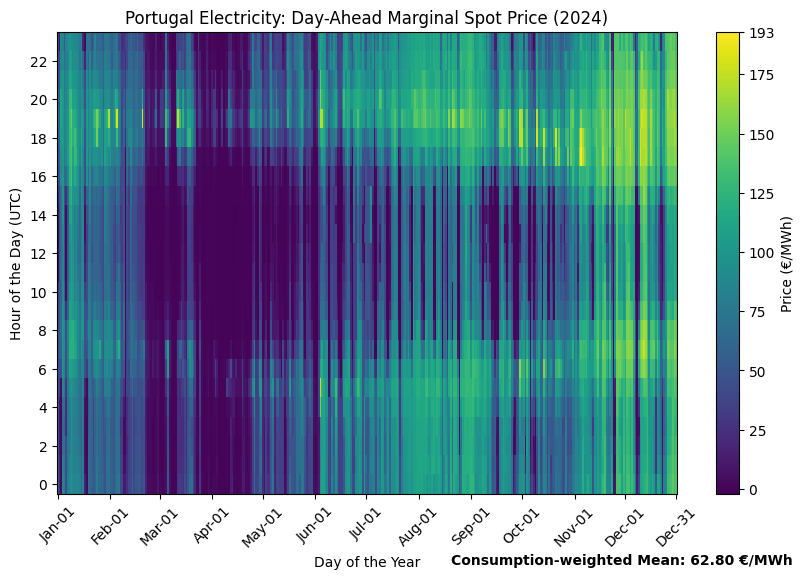

In [76]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

# Extract month and day for better labeling
hours_of_day = prices_df.index.hour  # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = prices_df["PT"]

# Calculate the total net exports
total_net_exports = color_values.sum() * 1000

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('viridis')  # Use the 'coolwarm' colormap

# # Calculate the relative positions for cropping the colormap
# cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
# cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# # Create a cropped colormap based on the calculated range
# cmap = LinearSegmentedColormap.from_list(
#     cmap.name,
#     cmap(np.linspace(cmap_min, cmap_max, 256))
# )

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    prices_df.index.dayofyear,  # Keep days aligned with integer values
    hours_of_day,  # Keep hours aligned with integer values
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cmap,  # Use the colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Price (€/MWh)")  # Add a color bar
initial_ticks = cbar.get_ticks()
new_ticks = np.unique(np.concatenate(([vmax], initial_ticks[1:-1])))
cbar.set_ticks(new_ticks)
cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

plt.title('Portugal Electricity: Day-Ahead Marginal Spot Price (2024)')  # Add a title
plt.xlabel('Day of the Year')  # Change label to 'Date'
plt.ylabel('Hour of the Day (UTC)')  # Label for y-axis

plt.suptitle(f'Consumption-weighted Mean: {price_avg_weighted:.2f} €/MWh', fontsize=10, fontweight='bold', x=0.69, y=0.01)  # Add a bold subtitle for total net exports

# Set x-axis ticks to show the first day of each month and December 31st
month_start_days = prices_df.resample('MS').first().index.dayofyear  # Get first day of each month
dec_31 = [366] if 366 in prices_df.index.dayofyear else []  # Include Dec 31 if present
xtick_positions = np.concatenate((month_start_days, dec_31)) + 0.5  # Shift by 0.5 to center
xtick_labels = np.concatenate((prices_df.resample('MS').first().index.strftime('%b-%d'), ['Dec-31']))

plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.yticks(np.arange(0, 24, 2) + 0.5, np.arange(0, 24, 2))  # Center y-ticks but keep original labels
plt.show()  # Display the plot


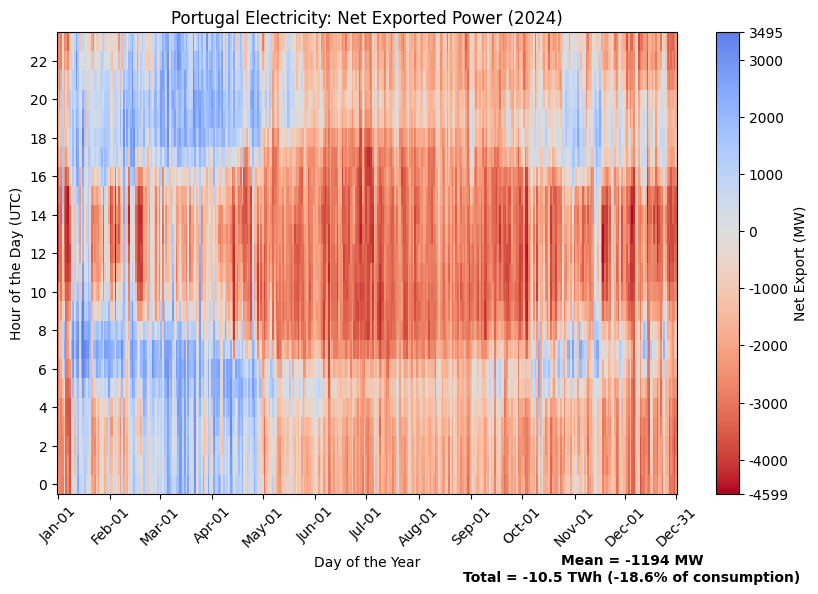

In [71]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

days_of_year = prices_df.index.dayofyear  # Day of the year (1-365/366)
hours_of_day = prices_df.index.hour       # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = (exports - imports)

# Calculate the total net exports
min_net_exports = color_values.min() 
max_net_exports = color_values.max()
avg_net_exports = color_values.mean()
total_net_exports_twh = color_values.sum()/1000/1000

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('coolwarm_r')  # Use the reversed version of the 'PiYG' colormap

# Calculate the relative positions for cropping the colormap
cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# Create a cropped colormap based on the calculated range
cropped_cmap = LinearSegmentedColormap.from_list(
    cmap.name,
    cmap(np.linspace(cmap_min, cmap_max, 256))
)

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    days_of_year, 
    hours_of_day, 
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cropped_cmap,    # Use the cropped colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Net Export (MW)")  # Add a color bar

# Preserve the initial ticks and add min and max ticks
initial_ticks = cbar.get_ticks()  # Get the default ticks
new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))  # Add vmin and vmax while keeping existing ticks
cbar.set_ticks(new_ticks)
cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

# Add the total net exports information as a subtitle
plt.suptitle(f'Mean = {avg_net_exports:.0f} MW\nTotal = {total_net_exports_twh:.1f} TWh (-18.6% of consumption)', fontsize=10, fontweight='bold', x=0.7, y=0.01)  # Add a bold subtitle for total net exports
plt.title('Portugal Electricity: Net Exported Power (2024)')  # Add a title
plt.xlabel('Day of the Year')  # Label for x-axis
plt.ylabel('Hour of the Day (UTC)')  # Label for y-axis

month_start_days = prices_df.resample('MS').first().index.dayofyear  # Get first day of each month
dec_31 = [366] if 366 in prices_df.index.dayofyear else []  # Include Dec 31 if present
xtick_positions = np.concatenate((month_start_days, dec_31)) + 0.5  # Shift by 0.5 to center
xtick_labels = np.concatenate((prices_df.resample('MS').first().index.strftime('%b-%d'), ['Dec-31']))

plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.yticks(np.arange(0, 24, 2) + 0.5, np.arange(0, 24, 2))  # Center y-ticks but keep original labels
plt.show()  # Display the plot

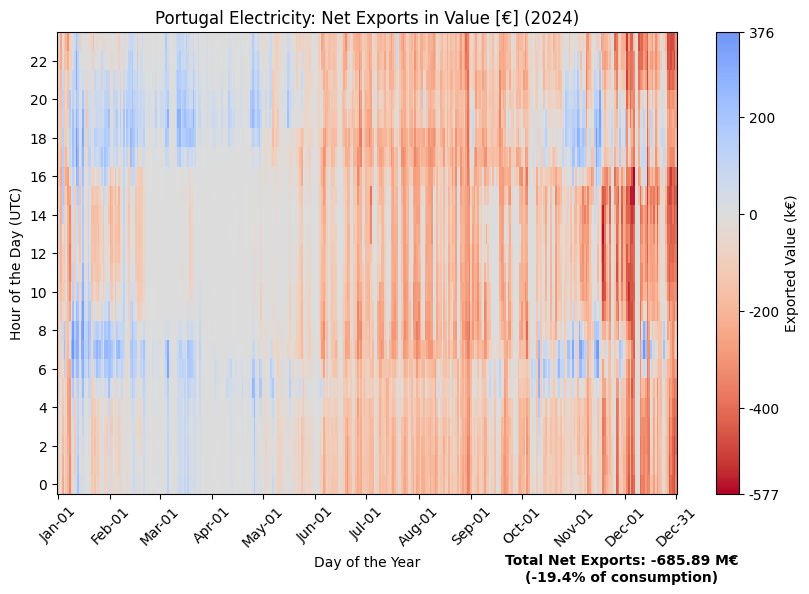

In [72]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

days_of_year = prices_df.index.dayofyear  # Day of the year (1-365/366)
hours_of_day = prices_df.index.hour       # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = (exports - imports) * prices_df["PT"] / 1000

# Calculate the total net exports
total_net_exports = ((exports - imports) * prices_df["PT"]).sum()

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('coolwarm_r')  # Use the reversed version of the 'PiYG' colormap

# Calculate the relative positions for cropping the colormap
cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# Create a cropped colormap based on the calculated range
cropped_cmap = LinearSegmentedColormap.from_list(
    cmap.name,
    cmap(np.linspace(cmap_min, cmap_max, 256))
)

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    days_of_year, 
    hours_of_day, 
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cropped_cmap,    # Use the cropped colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Exported Value (k€)")  # Add a color bar

# Preserve the initial ticks and add min and max ticks
initial_ticks = cbar.get_ticks()  # Get the default ticks
new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))  # Add vmin and vmax while keeping existing ticks
cbar.set_ticks(new_ticks)
cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

# Add the total net exports information as a subtitle
plt.suptitle(f'Total Net Exports: {total_net_exports/1e6:.2f} M€\n(-19.4% of consumption)', fontsize=10, fontweight='bold', x=0.69, y=0.01)  # Add a subtitle for total net exports
plt.title('Portugal Electricity: Net Exports in Value [€] (2024)')  # Add a title
plt.xlabel('Day of the Year')  # Label for x-axis
plt.ylabel('Hour of the Day (UTC)')  # Label for y-axis


month_start_days = prices_df.resample('MS').first().index.dayofyear  # Get first day of each month
dec_31 = [366] if 366 in prices_df.index.dayofyear else []  # Include Dec 31 if present
xtick_positions = np.concatenate((month_start_days, dec_31)) + 0.5  # Shift by 0.5 to center
xtick_labels = np.concatenate((prices_df.resample('MS').first().index.strftime('%b-%d'), ['Dec-31']))

plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.yticks(np.arange(0, 24, 2) + 0.5, np.arange(0, 24, 2))  # Center y-ticks but keep original labels
plt.show()  # Display the plot


In [49]:
contributions["PT"][["B10", "B11", "B12"]].sum(axis=1)

start_time
2024-01-01 00:00:00    1841.0
2024-01-01 01:00:00    1128.0
2024-01-01 02:00:00    1487.0
2024-01-01 03:00:00    1198.0
2024-01-01 04:00:00    1224.0
                        ...  
2024-12-31 19:00:00    4031.0
2024-12-31 20:00:00    3283.0
2024-12-31 21:00:00    1777.0
2024-12-31 22:00:00    1422.0
2024-12-31 23:00:00     880.0
Length: 8784, dtype: float64

In [43]:
valor_consumo = (prices_df["PT"]*consumption).sum()
total_net_exports/valor_consumo

np.float64(-0.19420194976116195)

In [63]:
total_net_exports_twh*1000000/consumption.sum()

np.float64(-0.1864880649966916)

# Hidraulicidade

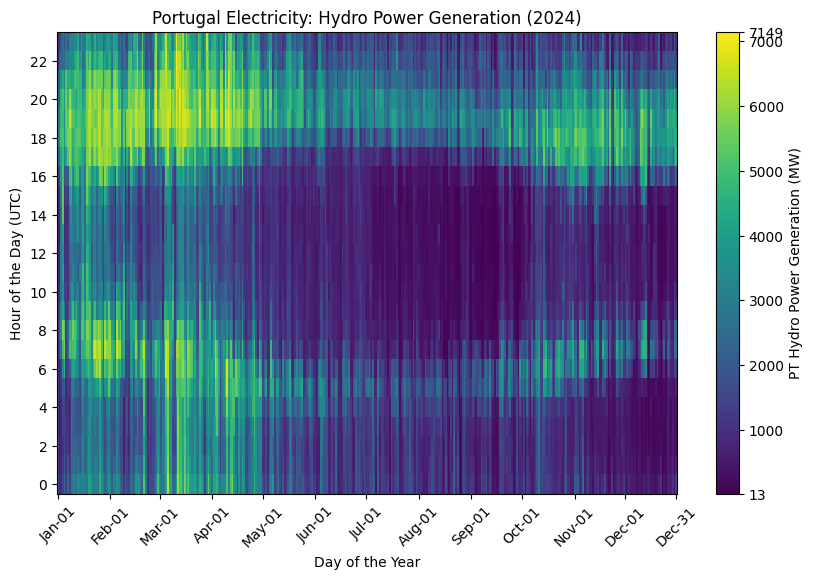

In [54]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

# Extract month and day for better labeling
hours_of_day = prices_df.index.hour  # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = contributions["PT"][["B10", "B11", "B12"]].sum(axis=1)
color_values = fetcher_data.generation_pt[["B10", "B11", "B12"]].sum(axis=1)

# Calculate the total net exports
total_net_exports = color_values.sum() * 1000

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('viridis')  # Use the 'coolwarm' colormap

# # Calculate the relative positions for cropping the colormap
# cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
# cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# # Create a cropped colormap based on the calculated range
# cmap = LinearSegmentedColormap.from_list(
#     cmap.name,
#     cmap(np.linspace(cmap_min, cmap_max, 256))
# )

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    prices_df.index.dayofyear,  # Keep days aligned with integer values
    hours_of_day,  # Keep hours aligned with integer values
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cmap,  # Use the colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="PT Hydro Power Generation (MW)")  # Add a color bar
initial_ticks = cbar.get_ticks()
new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))
cbar.set_ticks(new_ticks)
cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

plt.title('Portugal Electricity: Hydro Power Generation (2024)')  # Add a title
plt.xlabel('Day of the Year')  # Change label to 'Date'
plt.ylabel('Hour of the Day (UTC)')  # Label for y-axis

# plt.suptitle(f'Weighted Mean: {price_avg_weighted:.2f} €/MWh', fontsize=10, fontweight='bold', x=0.71, y=0.01)  # Add a bold subtitle for total net exports

# Set x-axis ticks to show the first day of each month and December 31st
month_start_days = prices_df.resample('MS').first().index.dayofyear  # Get first day of each month
dec_31 = [366] if 366 in prices_df.index.dayofyear else []  # Include Dec 31 if present
xtick_positions = np.concatenate((month_start_days, dec_31)) + 0.5  # Shift by 0.5 to center
xtick_labels = np.concatenate((prices_df.resample('MS').first().index.strftime('%b-%d'), ['Dec-31']))

plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.yticks(np.arange(0, 24, 2) + 0.5, np.arange(0, 24, 2))  # Center y-ticks but keep original labels
plt.show()  # Display the plot


# Potência eólica + solar

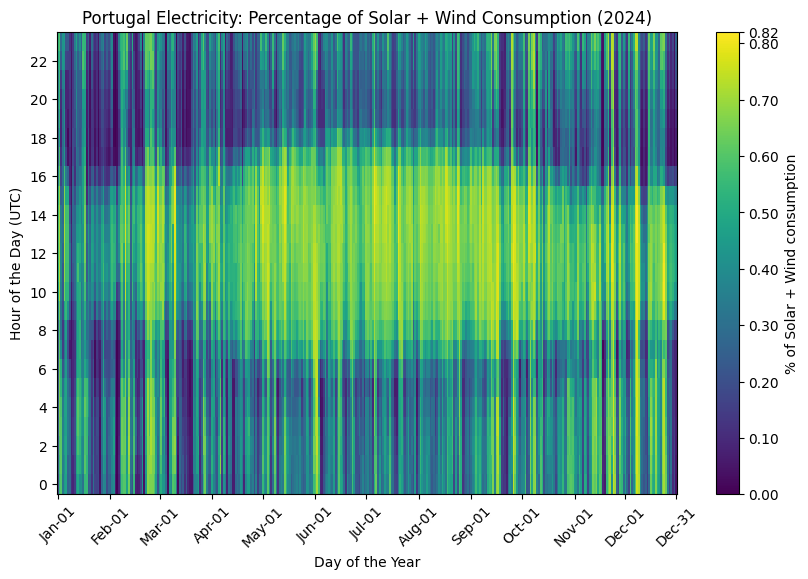

In [61]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

# Extract month and day for better labeling
hours_of_day = prices_df.index.hour  # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = fetcher_data.generation_pt[["B16", "B19"]].sum(axis=1)/consumption
color_values = aggregated[["B16", "B19"]].sum(axis=1)/consumption

# Calculate the total net exports
total_net_exports = color_values.sum() * 1000

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('viridis')  # Use the 'coolwarm' colormap

# # Calculate the relative positions for cropping the colormap
# cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
# cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# # Create a cropped colormap based on the calculated range
# cmap = LinearSegmentedColormap.from_list(
#     cmap.name,
#     cmap(np.linspace(cmap_min, cmap_max, 256))
# )

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    prices_df.index.dayofyear,  # Keep days aligned with integer values
    hours_of_day,  # Keep hours aligned with integer values
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cmap,  # Use the colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="% of Solar + Wind consumption")  # Add a color bar
initial_ticks = cbar.get_ticks()
new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))
cbar.set_ticks(new_ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in new_ticks])

plt.title('Portugal Electricity: Percentage of Solar + Wind Consumption (2024)')  # Add a title
plt.xlabel('Day of the Year')  # Change label to 'Date'
plt.ylabel('Hour of the Day (UTC)')  # Label for y-axis

# plt.suptitle(f'Weighted Mean: {price_avg_weighted:.2f} €/MWh', fontsize=10, fontweight='bold', x=0.71, y=0.01)  # Add a bold subtitle for total net exports

# Set x-axis ticks to show the first day of each month and December 31st
month_start_days = prices_df.resample('MS').first().index.dayofyear  # Get first day of each month
dec_31 = [366] if 366 in prices_df.index.dayofyear else []  # Include Dec 31 if present
xtick_positions = np.concatenate((month_start_days, dec_31)) + 0.5  # Shift by 0.5 to center
xtick_labels = np.concatenate((prices_df.resample('MS').first().index.strftime('%b-%d'), ['Dec-31']))

plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.yticks(np.arange(0, 24, 2) + 0.5, np.arange(0, 24, 2))  # Center y-ticks but keep original labels
plt.show()  # Display the plot


np.float64(-0.1864880649966916)

In [ ]:
total_net_exports_twh/(consumption.sum()/1000000)

In [25]:
(exports - imports).mean()

np.float64(-1194.0390482695811)

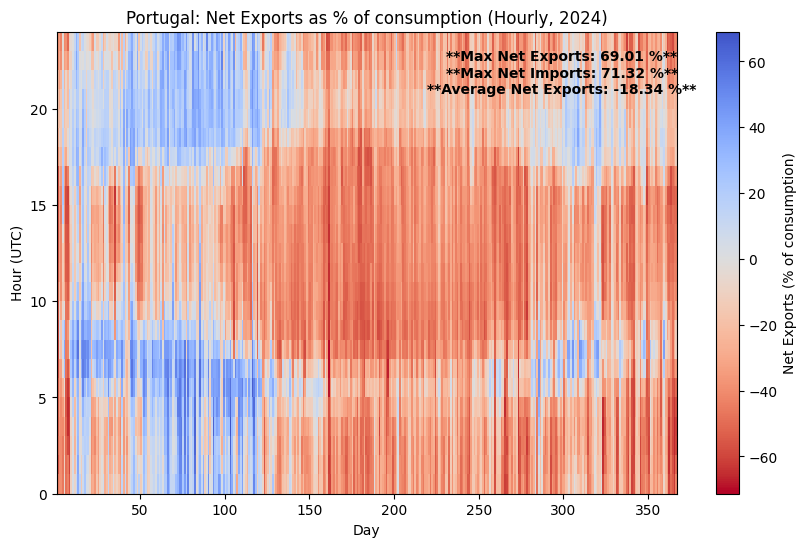

In [46]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

days_of_year = prices_df.index.dayofyear  # Day of the year (1-365/366)
hours_of_day = prices_df.index.hour       # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = (exports - imports) / consumption * 100

# Calculate the total net exports
max_net_imports = - color_values.min() 
max_net_exports = color_values.max()
avg_net_exports = color_values.mean()

# Calculate vmin and vmax
vmin = color_values.min()
vmax = color_values.max()
max_abs = max(abs(vmin), abs(vmax))

# Get the original colormap
cmap = plt.get_cmap('coolwarm_r')  # Use the reversed version of the 'PiYG' colormap

# Calculate the relative positions for cropping the colormap
cmap_min = (vmin - (-max_abs)) / (2 * max_abs)
cmap_max = (vmax - (-max_abs)) / (2 * max_abs)

# Create a cropped colormap based on the calculated range
cropped_cmap = LinearSegmentedColormap.from_list(
    cmap.name,
    cmap(np.linspace(cmap_min, cmap_max, 256))
)

plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    days_of_year, 
    hours_of_day, 
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cropped_cmap,    # Use the cropped colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Net Exports (% of consumption)")  # Add a color bar

# Preserve the initial ticks and add min and max ticks
# initial_ticks = cbar.get_ticks()  # Get the default ticks
# new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))  # Add vmin and vmax while keeping existing ticks
# cbar.set_ticks(new_ticks)
# cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

# Add the total net exports information as a subtitle
plt.suptitle(f'**Max Net Exports: {max_net_exports:.2f} %**\n**Max Net Imports: {max_net_imports:.2f} %**\n**Average Net Exports: {avg_net_exports:.2f} %**', fontsize=10, x=0.63, y=0.85, fontweight='bold')  # Add a bold subtitle for total net exports
plt.title('Portugal: Net Exports as % of consumption (Hourly, 2024)')  # Add a title
plt.xlabel('Day')  # Label for x-axis
plt.ylabel('Hour (UTC)')  # Label for y-axis
plt.show()  # Display the plot


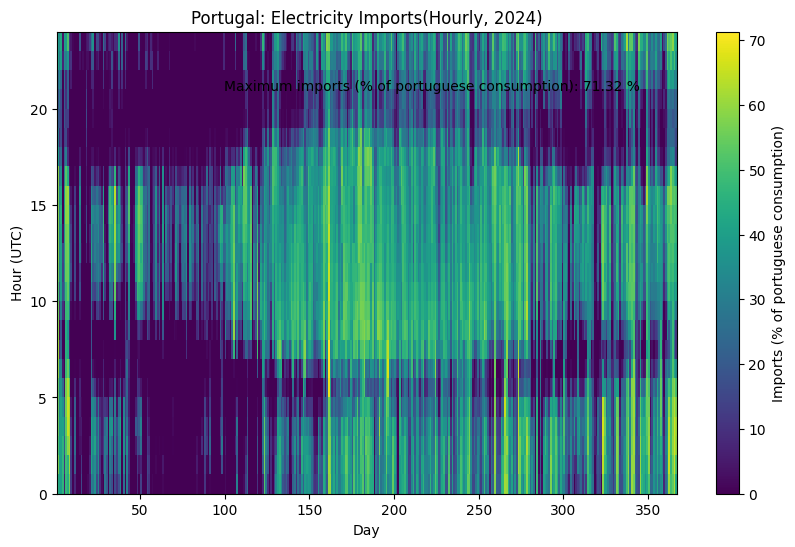

In [24]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

days_of_year = prices_df.index.dayofyear  # Day of the year (1-365/366)
hours_of_day = prices_df.index.hour       # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = percentage_imports

# Calculate the total net exports
maximum_imports = percentage_imports.max()

# Calculate vmin and vmax

# Get the original colormap
cmap = plt.get_cmap('viridis')  # Use the reversed version of the 'PiYG' colormap


plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    days_of_year, 
    hours_of_day, 
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cmap,    # Use the cropped colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Imports (% of portuguese consumption)")  # Add a color bar

# Preserve the initial ticks and add min and max ticks
initial_ticks = cbar.get_ticks()  # Get the default ticks
# new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))  # Add vmin and vmax while keeping existing ticks
# cbar.set_ticks(new_ticks)
# cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

# Add the total net exports information as a subtitle
plt.suptitle(f'Maximum imports (% of portuguese consumption): {maximum_imports:.2f} %', fontsize=10, y=0.8)  # Add a subtitle for total net exports
plt.title('Portugal: Electricity Imports(Hourly, 2024)')  # Add a title
plt.xlabel('Day')  # Label for x-axis
plt.ylabel('Hour (UTC)')  # Label for y-axis
plt.show()  # Display the plot


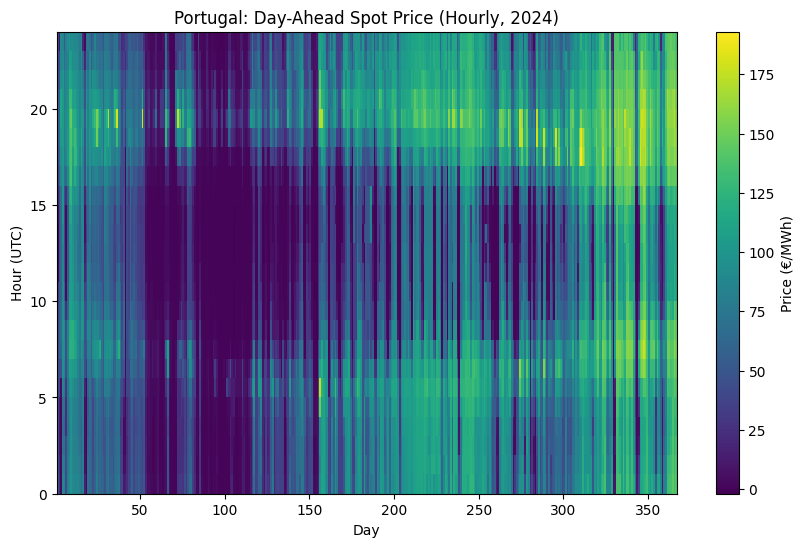

In [25]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.ticker as ticker  # Import ticker for formatting the colorbar

days_of_year = prices_df.index.dayofyear  # Day of the year (1-365/366)
hours_of_day = prices_df.index.hour       # Hour of the day (0-23)

# Calculate the color values as exports * prices_df["PT"]
color_values = prices_df["PT"]

# Calculate the total net exports
# maximum_imports = percentage_imports.max()

# Calculate vmin and vmax

# Get the original colormap
cmap = plt.get_cmap('viridis')  # Use the reversed version of the 'PiYG' colormap


plt.figure(figsize=(10, 6))
hist = plt.hist2d(
    days_of_year, 
    hours_of_day, 
    bins=[np.arange(1, 368), np.arange(0, 25)],  # 1 bin per day and hour
    weights=color_values,  # Use color_values for the histogram intensity
    cmap=cmap,    # Use the cropped colormap
)

# Add a color bar with formatted tick labels
cbar = plt.colorbar(hist[3], label="Price (€/MWh)")  # Add a color bar

# Preserve the initial ticks and add min and max ticks
initial_ticks = cbar.get_ticks()  # Get the default ticks
# new_ticks = np.unique(np.concatenate(([vmin, vmax], initial_ticks[1:-1])))  # Add vmin and vmax while keeping existing ticks
# cbar.set_ticks(new_ticks)
# cbar.set_ticklabels([f"{tick:.0f}" for tick in new_ticks])

# Add the total net exports information as a subtitle
# plt.suptitle(f'Maximum imports (% of portuguese consumption): {maximum_imports:.2f} %', fontsize=10, y=0.8)  # Add a subtitle for total net exports
plt.title('Portugal: Day-Ahead Spot Price (Hourly, 2024)')  # Add a title
plt.xlabel('Day')  # Label for x-axis
plt.ylabel('Hour (UTC)')  # Label for y-axis
plt.show()  # Display the plot


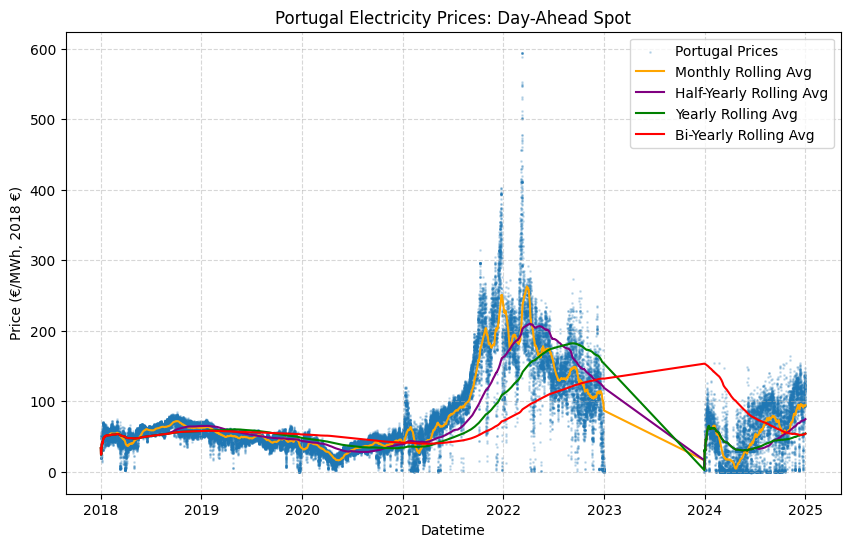

In [26]:
import matplotlib.pyplot as plt

# Inflation adjustments relative to 1955 levels
inflation_adjustments = {
    2018: 103211.42,
    2019: 103560.44,
    2020: 103547.51,
    2021: 104858.12,
    2022: 113071.32,
    2023: 117946.11,
    2024: 121707.8
}

# Normalize inflation adjustments to 2018 levels
normalized_inflation_adjustments = {
    year: value / inflation_adjustments[2018] for year, value in inflation_adjustments.items()
}

prices_df_2018_2024 = prices_df_all[(prices_df_all.index.year >= 2018) & (prices_df_all.index.year <= 2024)]

# Create a column for adjusted prices
prices_df_2018_2024["PT_2018_euros"] = prices_df_2018_2024.apply(
    lambda row: row["PT"] / normalized_inflation_adjustments[row.name.year], 
    axis=1
)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of adjusted prices
plt.scatter(prices_df_2018_2024.index, prices_df_2018_2024["PT_2018_euros"], alpha=0.2, s=1, label="Portugal Prices")

# Calculate and plot rolling averages for adjusted prices
rolling_averages = {
    "Monthly": prices_df_2018_2024["PT_2018_euros"].rolling('30D').mean(),
    "Half-Yearly": prices_df_2018_2024["PT_2018_euros"].rolling('182D').mean(),
    "Yearly": prices_df_2018_2024["PT_2018_euros"].rolling('365D').mean(),
    "Bi-Yearly": prices_df_2018_2024["PT_2018_euros"].rolling('730D').mean()
}

colors = {
    "Monthly": "orange",  # Change color for Monthly to avoid conflict with scatter
    "Half-Yearly": "purple",  # Changed from blue to purple
    "Yearly": "green",
    "Bi-Yearly": "red"
}

for label, data in rolling_averages.items():
    plt.plot(prices_df_2018_2024.index, data, label=f"{label} Rolling Avg", linewidth=1.5, color=colors[label])

# Add title, labels, legend, and grid
plt.title("Portugal Electricity Prices: Day-Ahead Spot")
plt.xlabel("Datetime")
plt.ylabel("Price (€/MWh, 2018 €)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

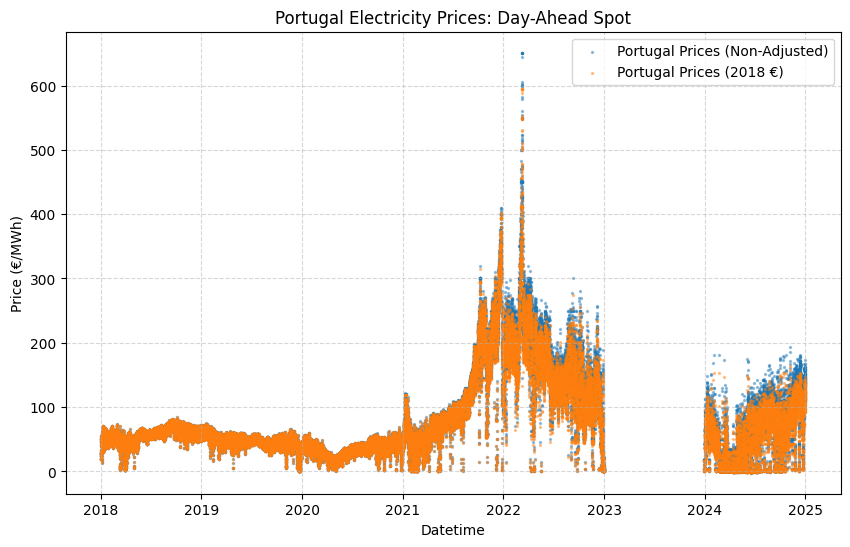

In [27]:
import matplotlib.pyplot as plt

# Inflation adjustments relative to 1955 levels
inflation_adjustments = {
    2018: 103211.42,
    2019: 103560.44,
    2020: 103547.51,
    2021: 104858.12,
    2022: 113071.32,
    2023: 117946.11,
    2024: 121707.8
}

# Normalize inflation adjustments to 2018 levels
normalized_inflation_adjustments = {
    year: value / inflation_adjustments[2018] for year, value in inflation_adjustments.items()
}

prices_df_2018_2024 = prices_df_all[(prices_df_all.index.year >= 2018) & (prices_df_all.index.year <= 2024)]

# Create a column for adjusted prices
prices_df_2018_2024["PT_2018_euros"] = prices_df_2018_2024.apply(
    lambda row: row["PT"] / normalized_inflation_adjustments[row.name.year], 
    axis=1
)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of non-inflation-adjusted prices
plt.scatter(prices_df_2018_2024.index, prices_df_2018_2024["PT"], alpha=0.4, s=2, label="Portugal Prices (Non-Adjusted)")

# Scatter plot of inflation-adjusted prices
plt.scatter(prices_df_2018_2024.index, prices_df_2018_2024["PT_2018_euros"], alpha=0.4, s=2, label="Portugal Prices (2018 €)")

# Add title, labels, legend, and grid
plt.title("Portugal Electricity Prices: Day-Ahead Spot")
plt.xlabel("Datetime")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [53]:
prices_df_all

,PT,ES,PT_2018_euros
datetime,,,
2017-12-31 23:00:00,28.10,6.74,28.10
2018-01-01 00:00:00,33.00,4.74,33.00
2018-01-01 01:00:00,32.90,3.66,32.90
2018-01-01 02:00:00,28.10,2.30,28.10
2018-01-01 03:00:00,27.60,2.30,27.60
...,...,...,...
2025-01-05 18:00:00,64.81,64.81,64.81
2025-01-05 19:00:00,65.20,65.20,65.20
2025-01-05 20:00:00,68.50,68.50,68.50


In [50]:
normalized_inflation_adjustments

{2018: 1.0,
 2019: 1.003381602539719,
 2020: 1.003256325705043,
 2021: 1.0159546298268156,
 2022: 1.095531095299338,
 2023: 1.1427622059651927,
 2024: 1.1792086573365623}

Wavelengths of the 4 highest peaks (in hours): [3.84300e+03 8.78400e+03 1.20000e+01 1.22976e+04]


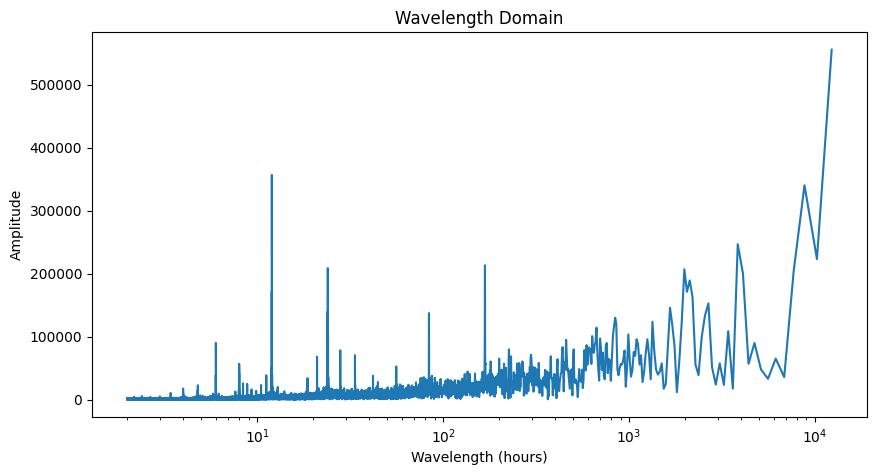

In [198]:
from scipy.fft import fft, fftfreq
import numpy as np

# Perform Fourier Transform
signal = prices_df_all['PT'].values
N = len(signal)
T = 1.0  # Sampling interval (1 hour)
freqs = fftfreq(N, T)[:N // 2]
fft_values = fft(signal)[:N // 2]

# Remove the peak at [0, 0.01]
mask = (freqs > 0.00007)  # Keep frequencies greater than 0.01
freqs = freqs[mask]
fft_values = fft_values[mask]

# Convert frequency to wavelength (hours)
wavelengths = 1 / freqs

# Find the 4 highest peaks
amplitudes = np.abs(fft_values)
peak_indices = np.argsort(amplitudes)[-4:]  # Indices of the 4 highest peaks
dominant_wavelengths = wavelengths[peak_indices]

# Print the wavelengths of the 4 highest peaks
print("Wavelengths of the 4 highest peaks (in hours):", dominant_wavelengths)

# Plot dominant wavelengths
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, amplitudes)
plt.title('Wavelength Domain')
plt.xlabel('Wavelength (hours)')
plt.ylabel('Amplitude')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.show()